In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jobathon2/train_s3TEQDk.csv
/kaggle/input/jobathon2/test_mSzZ8RL.csv
/kaggle/input/sample-jobathon/sample_submission_eyYijxG.csv


# JOBATHON Predictions Notebook

### This notebook will illustrate the approach adapted in the hackathon

# INDEX:
## 1. [DATA ANALYSIS](#dataanalysis)
## 2. [FEATURE ENGINEERING](#featureengineering)
## 3. [MODEL PREPARATION](#modelpreparation)
## 4. [MODEL EVALUATION AND PREDCTIONS](#modelevaluation)

# 1. DATA ANALYSIS<a id='dataanalysis'></a>

### Starting with importing all the necessary libraries for the task

In [37]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
pd.set_option('display.max_rows',None)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from category_encoders import LeaveOneOutEncoder

import optuna
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,roc_auc_score
from sklearn.model_selection import StratifiedKFold

## Importing the Comma Seperated Data Files

In [38]:
train = pd.read_csv('/kaggle/input/jobathon2/train_s3TEQDk.csv')
test = pd.read_csv('/kaggle/input/jobathon2/test_mSzZ8RL.csv')
sub = pd.read_csv('/kaggle/input/sample-jobathon/sample_submission_eyYijxG.csv')

## Getting some basic info about the train data

In [39]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [40]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [41]:
train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [42]:
# import pylab
# edges = pylab.hist(train['Age'], bins=10)[1]
# train['Age']= np.digitize(train['Age'], edges)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [44]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


## Using heatmap to check for some correlations between Numerical columns

<AxesSubplot:>

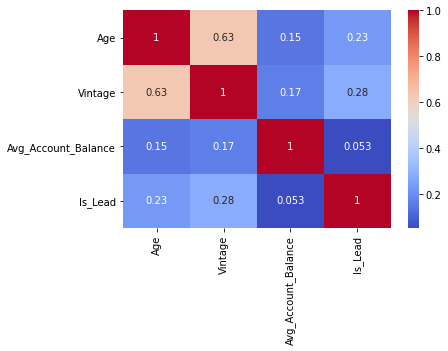

In [45]:
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

## Checking for Null values in the dataset 

In [46]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [47]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
dtype: int64

### Looks like Credit_Product column has some null values and most of the null values actually result in being a lead after all 
### These will be treated [here](#nullvalues)

## Checking for the unique values in columns

In [48]:
for i in train.columns:
    print(f"Number of Unique values in {i} are : {train[i].nunique()}")

Number of Unique values in ID are : 245725
Number of Unique values in Gender are : 2
Number of Unique values in Age are : 63
Number of Unique values in Region_Code are : 35
Number of Unique values in Occupation are : 4
Number of Unique values in Channel_Code are : 4
Number of Unique values in Vintage are : 66
Number of Unique values in Credit_Product are : 2
Number of Unique values in Avg_Account_Balance are : 135292
Number of Unique values in Is_Active are : 2
Number of Unique values in Is_Lead are : 2


## Checking for values outside training data
### Verifying if there are values present in test set which are absent in training set

In [49]:
set_columns=['Gender', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Is_Active']

In [50]:
for i in set_columns:
    print(f'Column {i}: {set(test[i].unique())-set(train[i].unique())}')
    print('')

Column Gender: set()

Column Region_Code: set()

Column Occupation: set()

Column Channel_Code: set()

Column Vintage: set()

Column Credit_Product: set()

Column Is_Active: set()



## Dividing the columns into numerical and categorical types

In [51]:
numerical_cols=['Age', 'Avg_Account_Balance']

categorical_cols=['Gender','Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
             'Credit_Product', 'Is_Active']

## Few prominent visualizations which will come in handy later 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

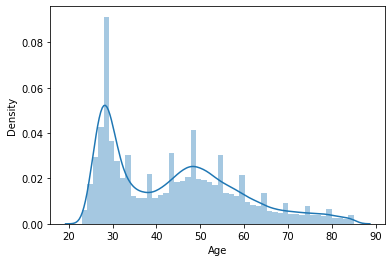

In [52]:
sns.distplot(train['Age'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Avg_Account_Balance', ylabel='Density'>

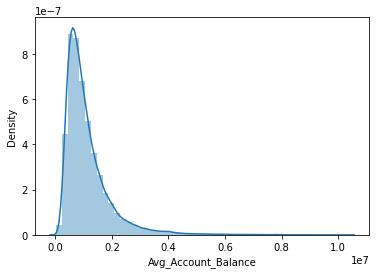

In [53]:
sns.distplot(train['Avg_Account_Balance'])

### Avg_Account_Balance looks skewed 
### This skewness is handled [here](#skewness)

# 2. FEATURE ENGINEERING<a id='featureengineering'></a>

## Treating null values of Credit_Product column<a id='nullvalues'></a>

### Replacing Null values with UNK column

In [54]:
train['Credit_Product'].fillna('UNK',inplace=True)
test['Credit_Product'].fillna('UNK',inplace=True)

## Dropping ID column since it doesn't contribute to the model building

In [55]:
train.drop(columns=['ID'],inplace=True)
test.drop(columns=['ID'],inplace=True)

## Removing skewness from data<a id='skewness'></a>

In [56]:
train['Avg_Account_Balance']=train['Avg_Account_Balance'].apply(lambda x: np.log(x+1))
test['Avg_Account_Balance']=test['Avg_Account_Balance'].apply(lambda x: np.log(x+1))

## Removing the outliers in columns using boxplot method

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Avg_Account_Balance'>

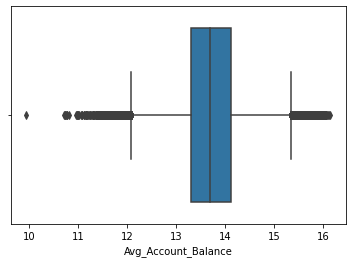

In [57]:
sns.boxplot(train['Avg_Account_Balance'])

In [58]:
Q1 = train['Avg_Account_Balance'].quantile(0.25)

Q3 = train['Avg_Account_Balance'].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

In [59]:
a=train[(train['Avg_Account_Balance']>Upper_Fence)|(train['Avg_Account_Balance']<Lower_Fence)].index
train.drop(a,inplace=True)

## Removing unwanted outliers from Age based on Channel Code

<AxesSubplot:xlabel='Channel_Code', ylabel='Age'>

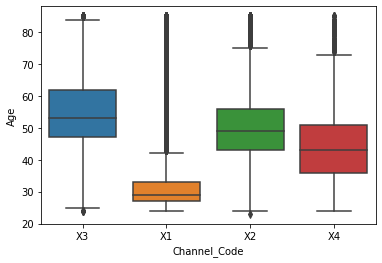

In [60]:
sns.boxplot(x=train['Channel_Code'],y=train['Age'])

In [61]:
Q1 = train[train['Channel_Code']=='X1']['Age'].quantile(0.25)

Q3 = train[train['Channel_Code']=='X1']['Age'].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

a=train[(train['Channel_Code']=='X1')&((train['Age']>Upper_Fence)|(train['Age']<Lower_Fence))].index
train.drop(a,inplace=True)

In [62]:
Q1 = train[train['Channel_Code']=='X2']['Age'].quantile(0.25)

Q3 = train[train['Channel_Code']=='X2']['Age'].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

a=train[(train['Channel_Code']=='X2')&((train['Age']>Upper_Fence)|(train['Age']<Lower_Fence))].index
train.drop(a,inplace=True)

In [63]:
Q1 = train[train['Channel_Code']=='X3']['Age'].quantile(0.25)

Q3 = train[train['Channel_Code']=='X3']['Age'].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

a=train[(train['Channel_Code']=='X3')&((train['Age']>Upper_Fence)|(train['Age']<Lower_Fence))].index
train.drop(a,inplace=True)

In [64]:
Q1 = train[train['Channel_Code']=='X4']['Age'].quantile(0.25)

Q3 = train[train['Channel_Code']=='X4']['Age'].quantile(0.75)

IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR)

Upper_Fence = Q3 + (1.5 * IQR)

a=train[(train['Channel_Code']=='X4')&((train['Age']>Upper_Fence)|(train['Age']<Lower_Fence))].index
train.drop(a,inplace=True)

## Below box plot has outliers only in Channel_Code X1, but removing them is not affecting the model positively, hence these outliers were not removed from the model

<AxesSubplot:xlabel='Channel_Code', ylabel='Vintage'>

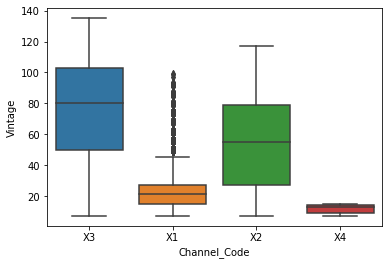

In [65]:
sns.boxplot(x=train['Channel_Code'],y=train['Vintage'])

In [66]:
# Q1 = train[train['Channel_Code']=='X1']['Vintage'].quantile(0.25)

# Q3 = train[train['Channel_Code']=='X1']['Vintage'].quantile(0.75)

# IQR = Q3 - Q1

# Lower_Fence = Q1 - (1.5 * IQR)

# Upper_Fence = Q3 + (1.5 * IQR)

# a=train[(train['Channel_Code']=='X1')&((train['Vintage']>Upper_Fence)|(train['Vintage']<Lower_Fence))].index
# train.drop(a,inplace=True)

## Scaling the Columns using Standard scaler method

In [67]:
sc_cols=['Age','Vintage']

sc = StandardScaler()
train[numerical_cols]=sc.fit_transform(train[numerical_cols])
test[numerical_cols]=sc.transform(test[numerical_cols])

## Dropping Region Code since it is low information variable

In [68]:
train.drop(columns=['Region_Code'],inplace=True)
test.drop(columns=['Region_Code'],inplace=True)

## Dividing the columns for dummies and ordinal encoding methods respectively

In [69]:
dummie_col = ['Is_Active','Gender','Channel_Code','Occupation','Credit_Product']
# ordinal_col = ['Region_Code']
# target_col = []

In [70]:
train = pd.get_dummies(train,columns=dummie_col,drop_first=True)
test = pd.get_dummies(test,columns=dummie_col,drop_first=True)

# oe=OrdinalEncoder()
# train[ordinal_col]=oe.fit_transform(train[ordinal_col])
# test[ordinal_col]=oe.transform(test[ordinal_col])
# le=LeaveOneOutEncoder()
# train[target_col]=le.fit_transform(train[target_col],train['Is_Lead'])
# test[target_col]=le.transform(test[target_col])

## Checking Heatmap again before training

<AxesSubplot:>

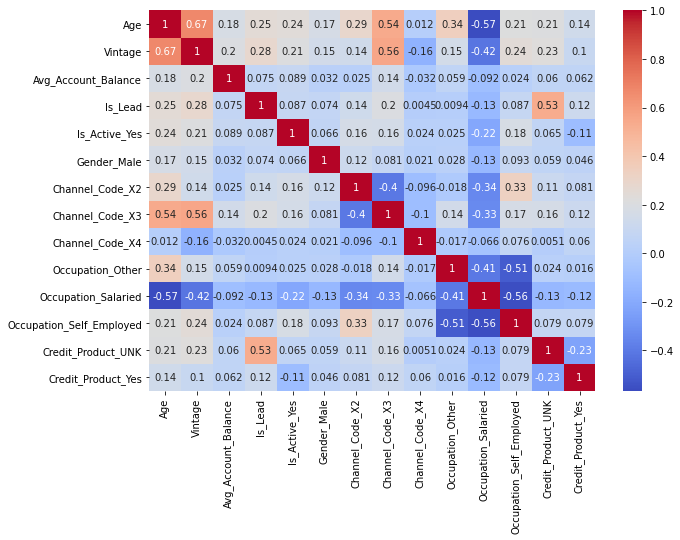

In [71]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

# MODEL PREPARATION<A id='modelpreparation'></A>

In [88]:
X=train.drop(columns=['Is_Lead'])
y=train['Is_Lead']

## Using Optuna for parameter tunning 
### LGBMClassier was the best performing model among many other models including XGBClassfier,CatBoostClassfier and RandomForestClassfier

In [73]:
import optuna
data=X
target=y

def objective(trial , data = data , target = target):
    train_x , test_x , train_y , test_y = train_test_split(data , target , \
            test_size = 0.2 ,stratify=target, random_state = 42)
    
    params = {
        'reg_alpha' : trial.suggest_loguniform('reg_alpha' , 1e-5 , 10),
        'reg_lambda' : trial.suggest_loguniform('reg_lambda' , 1e-5 , 10),
        'num_leaves' : trial.suggest_int('num_leaves' , 11 , 300),
        'learning_rate' : trial.suggest_uniform('learning_rate' , 0 , 0.1),
        'max_depth' : trial.suggest_int('max_depth' , 5 , 20),
        'n_estimators' : trial.suggest_int('n_estimators' , 1 , 9999),
        'min_child_samples' : trial.suggest_int('min_child_samples' , 1 , 100),
        'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
        'subsample' : trial.suggest_uniform('subsample' , 0 , 1.0),
        'colsample_bytree' : trial.suggest_loguniform('colsample_bytree' , 1e-5 , 1),
        'random_state' : trial.suggest_categorical('random_state' , [0,42,2021,555]),
        'metric' : 'auc',
    }
    model = LGBMClassifier(**params)
    model.fit(train_x , train_y , eval_set = [(test_x , test_y)] , early_stopping_rounds = 200 , \
             verbose = False)
    preds = model.predict_proba(test_x)[:,1]
    auc = roc_auc_score(test_y , preds)
    return auc

study = optuna.create_study(direction = 'maximize' , study_name = 'lgbm')
study.optimize(objective , n_trials = 50)
print('numbers of the finished trials:' , len(study.trials))
print('the best params:' , study.best_trial.params)
print('the best value:' , study.best_value)

[I 2021-05-30 12:37:55,054] A new study created in memory with name: lgbm
[I 2021-05-30 12:38:02,301] Trial 0 finished with value: 0.8749305398930309 and parameters: {'reg_alpha': 6.038773797774583, 'reg_lambda': 0.6960484576214623, 'num_leaves': 90, 'learning_rate': 0.07824726278166763, 'max_depth': 13, 'n_estimators': 3622, 'min_child_samples': 31, 'min_child_weight': 0.07868090518944854, 'subsample': 0.9863971523981376, 'colsample_bytree': 0.37390060865979713, 'random_state': 0}. Best is trial 0 with value: 0.8749305398930309.
[I 2021-05-30 12:38:05,065] Trial 1 finished with value: 0.8205112178025026 and parameters: {'reg_alpha': 0.000718708969194248, 'reg_lambda': 0.5831697525990177, 'num_leaves': 290, 'learning_rate': 0.0053444603920353335, 'max_depth': 13, 'n_estimators': 9066, 'min_child_samples': 6, 'min_child_weight': 0.00032000002142646984, 'subsample': 0.6511982447428116, 'colsample_bytree': 0.015866318542526132, 'random_state': 555}. Best is trial 0 with value: 0.874930539

numbers of the finished trials: 50
the best params: {'reg_alpha': 6.789744929589601, 'reg_lambda': 1.6480243813316007e-05, 'num_leaves': 20, 'learning_rate': 0.0995802256439286, 'max_depth': 20, 'n_estimators': 2699, 'min_child_samples': 46, 'min_child_weight': 0.4929730919382415, 'subsample': 0.9862710430942886, 'colsample_bytree': 0.7917248637711425, 'random_state': 0}
the best value: 0.8757236441931568


## Implementing LGBMClassifier using the best parameters

In [91]:
best_params={'reg_alpha': 6.789744929589601, 'reg_lambda': 1.6480243813316007e-05, 'num_leaves': 20,
             'learning_rate': 0.0995802256439286, 'max_depth': 20, 'n_estimators': 2699,
             'min_child_samples': 46, 'min_child_weight': 0.4929730919382415, 'subsample': 0.9862710430942886,
             'colsample_bytree': 0.7917248637711425, 'random_state': 0,'metric':'auc'}

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [93]:
# model = XGBClassifier(**best_params_xgb)
model=LGBMClassifier(**best_params)
# # model = LGBMClassifier(num_leaves= 300 , max_depth= 8 , reg_alpha= 5,random_state=123)
model.fit(X_train,y_train,eval_set = [(X_test, y_test)],early_stopping_rounds = 200,
          verbose=50)

Training until validation scores don't improve for 200 rounds
[50]	valid_0's auc: 0.875453
[100]	valid_0's auc: 0.875668
[150]	valid_0's auc: 0.87554
[200]	valid_0's auc: 0.87547
[250]	valid_0's auc: 0.875309
[300]	valid_0's auc: 0.875167
Early stopping, best iteration is:
[105]	valid_0's auc: 0.875724


LGBMClassifier(colsample_bytree=0.7917248637711425,
               learning_rate=0.0995802256439286, max_depth=20, metric='auc',
               min_child_samples=46, min_child_weight=0.4929730919382415,
               n_estimators=2699, num_leaves=20, random_state=0,
               reg_alpha=6.789744929589601, reg_lambda=1.6480243813316007e-05,
               subsample=0.9862710430942886)

# 4. MODEL EVALUATION AND PREDICTIONS<A id='modelevaluation'></A>

## Implementing AUC ROC Curve to Check the model

In [94]:
y = model.predict_proba(X_test)[:,1]

In [95]:
from numpy import argmax
fpr, tpr, thresholds = roc_curve(y_test, y)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.217437


Best Threshold=0.217437, G-Mean=0.808


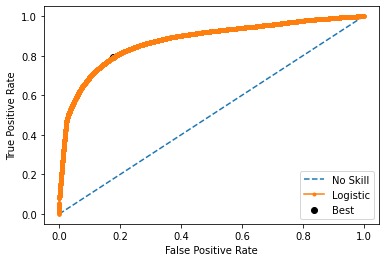

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, y)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [97]:
y_out = model.predict_proba(test)[:,1]

In [98]:
sub['Is_Lead']=y_out

In [99]:
sub.to_csv('prediction_dataset.csv', index = False)

In [100]:
y_valid = model.predict_proba(X_test)[:,1]

## Evaluating on the validation data using the metric provided

In [101]:
roc_auc_score(y_test,y)

0.8757236441931568

## Evaluating Feature Importance of LGBM

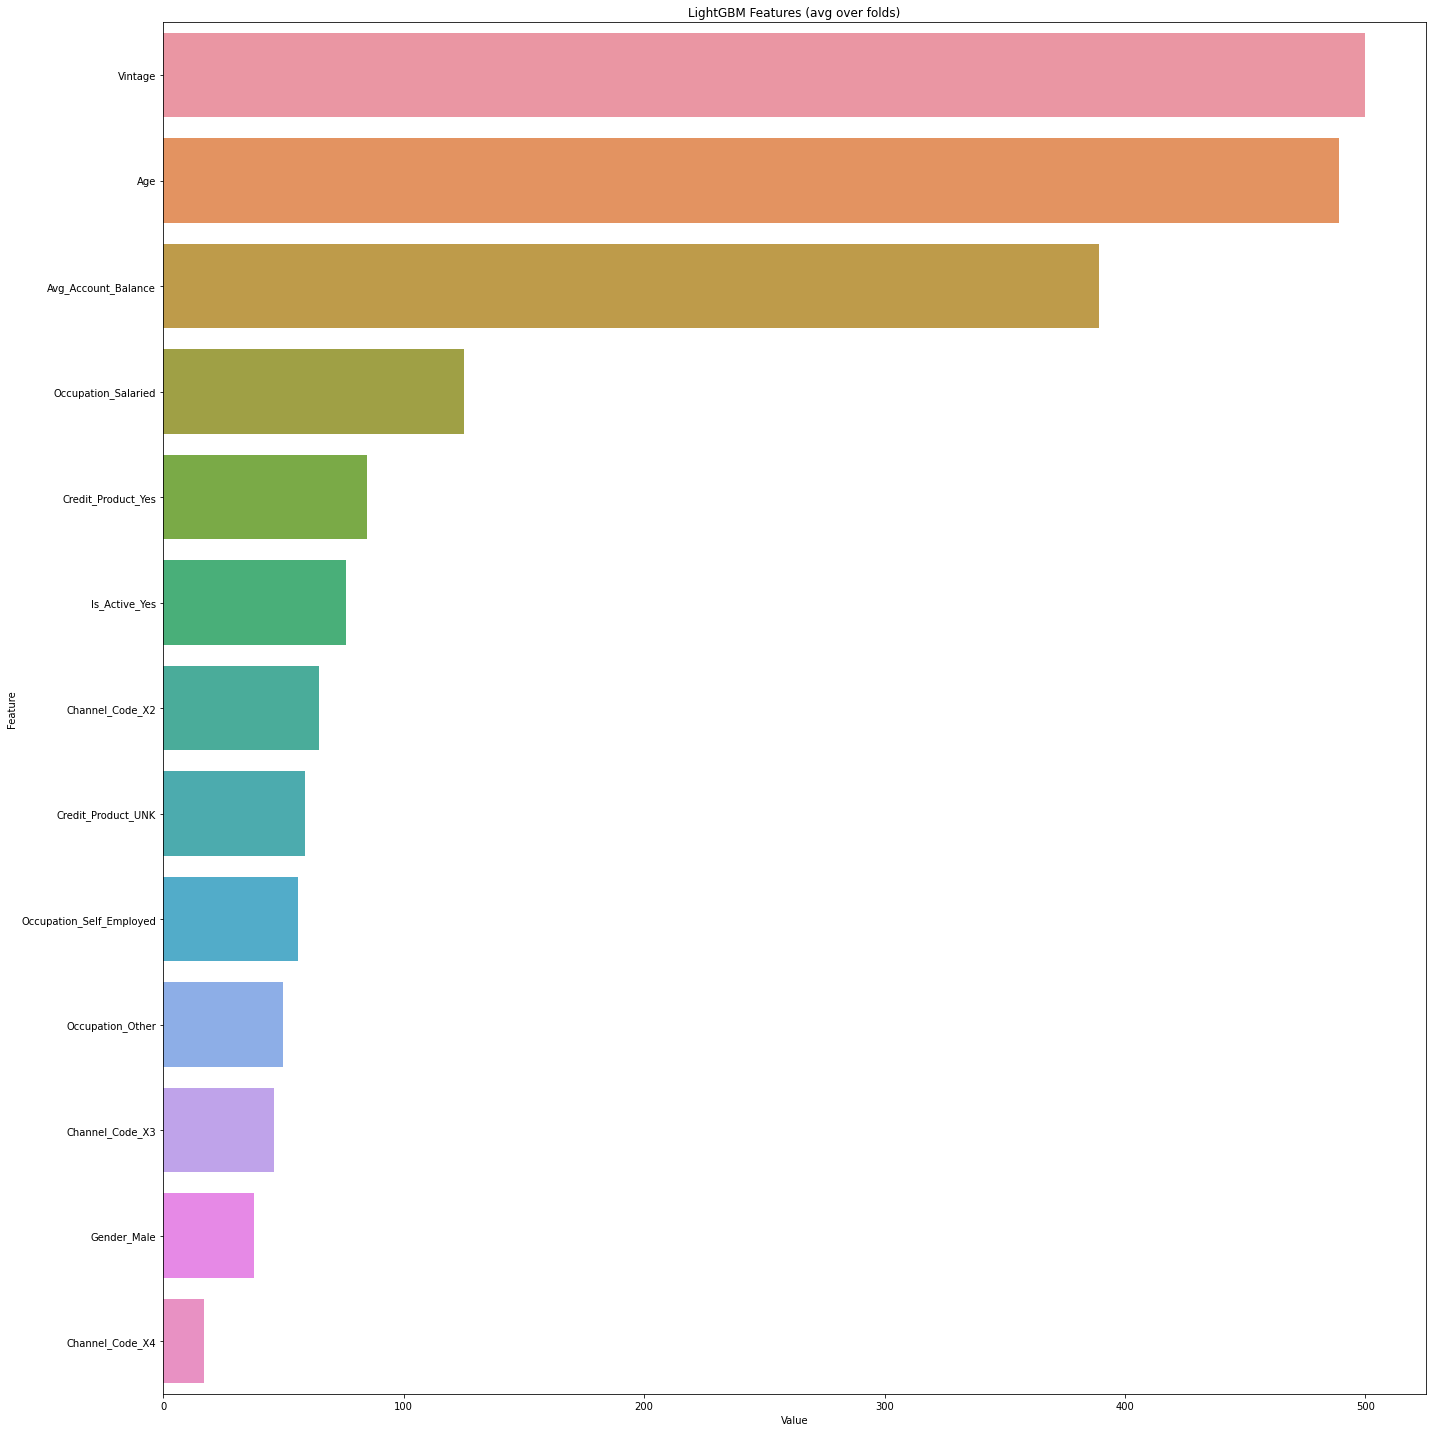

<Figure size 432x288 with 0 Axes>

In [102]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

## 